In [ ]:
import zipfile

In [ ]:
fantasy_zip = zipfile.ZipFile('./Stock_Dataset(2017_07_06).zip')
fantasy_zip.extractall('./data')

In [1]:
import pandas as pd
from pandas import Series, DataFrame
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import itertools

In [2]:
!pip install xlrd

  Using cached https://files.pythonhosted.org/packages/07/e6/e95c4eec6221bfd8528bcc4ea252a850bffcc4be88ebc367e23a1a84b0bb/xlrd-1.1.0-py2.py3-none-any.whl
mxnet-cu80 1.1.0 has requirement numpy<=1.13.3, but you'll have numpy 1.14.3 which is incompatible.


In [3]:
!pip install openpyxl

  Using cached https://files.pythonhosted.org/packages/a0/38/dcf83532480f25284f3ef13f8ed63e03c58a65c9d3ba2a6a894ed9497207/jdcal-1.4-py2.py3-none-any.whl
mxnet-cu80 1.1.0 has requirement numpy<=1.13.3, but you'll have numpy 1.14.3 which is incompatible.


In [3]:
### 메소드 정의 
# 상세 데이터를 가져온다.
def get_stock_datail(comp_code) :
    code = format(comp_code, "06d");
    return pd.read_csv('./data/' + code + '.csv')

# matrix 데이터로 변경한다.
def to_ndarray(cols_data) :
    if isinstance(cols_data, Series):
        return np.reshape(list(cols_data), (-1,1))
    elif isinstance(cols_data, DataFrame):
        return cols_data.as_matrix()

# 컬럼을 스케일링을 시킨다.
def get_scaled_cols(data, column_name) :
    scale_data = to_ndarray(data[column_name])
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(scale_data);

# 데이터를 스케일링 시킨다.
def get_scaled_data(data) :
    scaled_data = data.copy()
    scaled_data['Close'] = get_scaled_cols(scaled_data, 'Close')
    scaled_data['Open'] = get_scaled_cols(scaled_data, 'Open')
    scaled_data['High'] = get_scaled_cols(scaled_data, 'High')
    scaled_data['Low'] = get_scaled_cols(scaled_data, 'Low')
    scaled_data['Volume'] = get_scaled_cols(scaled_data, 'Volume')
    return scaled_data;

# RNN을 위한 데이터로 만든다. 
def get_dataXY(data, train_params) :
    x = to_ndarray(data[['Open', 'High', 'Low', 'Volume', 'Close']])
    y = to_ndarray(data['Close'])
    
    dataX = []
    dataY = []
    seq_length = train_params['seq_length']
    for i in range(0, len(y) - seq_length):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length] # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return dataX, dataY, y

# train 및 test 데이터로 나눈다.
def split_train_test(dataX, dataY, train_params, data, y) :
    invest_count = train_params['invest_count']
    seq_length = train_params['seq_length']
    data_count = len(dataY);
    train_size = int(data_count * train_params['train_percent'] / 100)
    train_last = data_count-invest_count;
    
    trainX = np.array(dataX[0:train_size])
    testX = np.array(dataX[train_size:train_last])
    investX = np.array(dataX[train_last:data_count])
    
    trainY = np.array(dataY[0:train_size])
    testY = np.array(dataY[train_size:train_last])
    investY = np.array(dataY[train_last:data_count])
    
    trainCloses = np.array( y[seq_length-1:train_size+seq_length-1])
    testCloses = np.array(dataY[train_size-1:train_last-1])
    investCloses = np.array(dataY[train_last-1:data_count-1])
    investRealCloses = np.array(data['Close'][train_last-1+seq_length:data_count-1+seq_length].values)
    
    return {
        'trainX': trainX, 'trainY': trainY, 'trainCloses': trainCloses,
        'testX': testX, 'testY': testY, 'testCloses' : testCloses,
        'investX': investX,'investY': investY, 'investCloses': investCloses, 'investRealCloses': investRealCloses
    }

# train, test데이터로 만든다.
def get_train_test(data, train_params) :
    scaled_data = get_scaled_data(data)
    dataX, dataY, y = get_dataXY(scaled_data, train_params)
    return split_train_test(dataX, dataY, train_params, data, y)

# 텐스플로우 변수관계 그래프롤 그린다.
def draw_graph(train_params) :
    seq_length = train_params['seq_length']
    data_dim = train_params['data_dim']
    hidden_dims = train_params['hidden_dims']
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    X_closes = tf.placeholder(tf.float32, [None, 1])
    Y = tf.placeholder(tf.float32, [None, 1])
    output_keep_prob = tf.placeholder(tf.float32)
    
    cells = []
    for n in hidden_dims :
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=n, activation=tf.tanh)
        dropout_cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=output_keep_prob)
        cells.append(dropout_cell)
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    outputs, _states = tf.nn.dynamic_rnn(dropout_cell, X, dtype=tf.float32) 
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], train_params['output_dim'], activation_fn=None)  # We use the last cell's output

    # cost/loss
    not_equal = tf.cast(tf.not_equal(tf.sign(X_closes-Y), tf.sign(X_closes-Y_pred)), tf.float32)
    loss = tf.reduce_sum(tf.square(Y_pred - Y) + not_equal)
        
    optimizer = tf.train.AdamOptimizer(train_params['learning_rate'])
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
    direction_error = tf.reduce_mean(
        tf.cast(tf.not_equal(tf.sign(X_closes-targets), tf.sign(X_closes-predictions)), tf.float32))
    
    return {
        'X': X,
        'Y': Y,
        'output_keep_prob': output_keep_prob,
        'train': train,
        'loss' : loss,
        'Y_pred': Y_pred,
        'targets': targets,
        'rmse' : rmse,
        'predictions': predictions,
        'X_closes' : X_closes,
        'direction_error' : direction_error
    }

def draw_plot(rmse_vals, test_predict, testY, train_params) :
    print('seq_length : ', train_params['seq_length'])
    print('hidden_dims : ', train_params['hidden_dims'])
    print('dropout_keep : ', train_params['dropout_keep'])
    print('rmse_vals : ', rmse_vals[len(rmse_vals)-1])
    plt.figure(1)
    plt.plot(rmse_vals, 'gold')
    plt.xlabel('Epoch(x100)')
    plt.ylabel('Root Mean Square Error')

    plt.figure(2)
    plt.plot(testY, 'r')
    plt.plot(test_predict, 'b')
    plt.xlabel('Time Period')
    plt.ylabel('Stock Price')
    plt.show()

# 학습을 시킨다.
def let_training(data_params, train_params, graph_params, comp_code) :
    X = graph_params['X']
    Y = graph_params['Y']
    output_keep_prob = graph_params['output_keep_prob']
    train = graph_params['train']
    loss = graph_params['loss']
    trainX = data_params['trainX']
    trainY = data_params['trainY']
    testX = data_params['testX']
    testY = data_params['testY']
    trainCloses = data_params['trainCloses']
    testCloses = data_params['testCloses']
    
    Y_pred = graph_params['Y_pred']
    targets = graph_params['targets']
    rmse = graph_params['rmse']
    predictions = graph_params['predictions']
    X_closes = graph_params['X_closes']
    direction_error = graph_params['direction_error']
    loss_up_count = train_params['loss_up_count']
    dropout_keep = train_params['dropout_keep']
    
#     saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        min_rmse_val = 999999
        min_direction_error_val = 999999
        less_cnt = 0
        train_count = 0
        rmse_vals = []
        
        for i in range(train_params['iterations']):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY, X_closes: trainCloses, output_keep_prob: dropout_keep})
            if i % 100 == 0 :
                test_predict = sess.run(Y_pred, feed_dict={X: testX, output_keep_prob: 1.0})
                rmse_val, direction_error_val = sess.run([rmse,  direction_error], feed_dict={targets: testY, predictions: test_predict, X_closes: testCloses}) 
                #print(step_loss, rmse_val, direction_error_val)
                #if rmse_val < min_rmse_val :
                rmse_vals.append(rmse_val)
                if direction_error_val + rmse_val < min_direction_error_val + min_rmse_val :
                #if direction_error_val < min_direction_error_val :
#                     tf.add_to_collection("X", X)
#                     tf.add_to_collection("X_closes", X_closes)
#                     tf.add_to_collection("Y", Y)
#                     tf.add_to_collection("train", train)
#                     tf.add_to_collection("Y_pred", Y_pred)
#                     tf.add_to_collection("output_keep_prob", output_keep_prob)
#                     saver.save(sess, "./sessions/" + str(comp_code) + ".ckpt")
                    less_cnt = 0
                    train_count = i;
                    max_test_predict, min_rmse_val, min_direction_error_val = test_predict, rmse_val, direction_error_val
                else :
                    less_cnt += 1
                if less_cnt > loss_up_count :
                    break
        draw_plot(rmse_vals, max_test_predict, testY, train_params) 
        return max_test_predict, min_rmse_val, min_direction_error_val, train_count 

# 그래프를 그리고 학습을 시킨다.    
def let_leaning(data_params, train_params, comp_code):
    graph_params = draw_graph(train_params)
    return let_training(data_params, train_params, graph_params, comp_code)

def to_dataFrame(data, columns) :
    return pd.DataFrame(data, columns=columns)

# excel로 저장한다.
def save_excel(df_data, file_name):
    writer = pd.ExcelWriter(file_name)
    df_data.to_excel(writer,'Sheet1', index=False)
    writer.save()

# 예측 값에 따라 매수 매도를 실행한다.    
def let_invest_money(invest_predict, now_scaled_close, now_close, train_params, now_money, now_stock_cnt) :
    seq_length = train_params['seq_length']
    data_dim = train_params['data_dim']
    pie_percent = train_params['pie_percent']
    invest_min_percent = train_params['invest_min_percent']
    
    ratio = (invest_predict - now_scaled_close) /now_scaled_close * 100
    
    if ratio > invest_min_percent :
        cnt = math.floor(now_money/now_close)
        if cnt > 0 :
            pie = now_close * pie_percent/100
            now_money -= (now_close + pie) * cnt
            now_stock_cnt += cnt
    elif ratio < -invest_min_percent :
        if now_stock_cnt > 0 :
            now_money += to_money(now_close, now_stock_cnt, train_params)
            now_stock_cnt = 0
    #print(now_money, now_stock_cnt, now_scaled_close, invest_predict, data_params['testY'])
    return now_money, now_stock_cnt

# 주식매도를 해서 돈으로 바꾼다.
def to_money(now_stock_cnt, now_close, train_params) :
    money = 0
    if now_stock_cnt > 0 :
        pie_percent = train_params['pie_percent'] 
        tax_percent = train_params['tax_percent']
        
        pie = now_close * pie_percent/100
        tax = now_close * tax_percent/100
        money = (now_close - (pie + tax)) * now_stock_cnt
    return money
    
# 학습 후 모의 주식 거래를 한다.
def let_invest(row, train_params, data_params, train_cnt):
    comp_code = row['종목코드']
    invest_count = train_params['invest_count']
    invest_money = train_params['invest_money']
    dropout_keep = train_params['dropout_keep']
    
    investX = data_params['investX']
    investCloses = data_params['investCloses']
    investRealCloses = data_params['investRealCloses']
    investX = data_params['investX']
    investY = data_params['investY']
    testX = data_params['testX']
    testY = data_params['testY']
    testCloses = data_params['testCloses']
    #print(investRealCloses)
    
    now_stock_cnt = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        saver.restore(sess, "./sessions/" + str(comp_code) + ".ckpt") 
        X = tf.get_collection('X')[0]
        X_closes = tf.get_collection('X_closes')[0]
        Y = tf.get_collection('Y')[0]
        train = tf.get_collection('train')[0]
        Y_pred = tf.get_collection('Y_pred')[0]
        output_keep_prob = tf.get_collection('output_keep_prob')[0]
        
        for i in range(int(train_cnt/10)):
            sess.run(train, feed_dict={X: testX, Y: testY, X_closes: testCloses, output_keep_prob: dropout_keep})
        
        for i in range(invest_count) :
            np.array([1, 2, 3], ndmin=2)
            invest_predicts = sess.run(Y_pred, feed_dict={X: investX[i:i+1], output_keep_prob: 1.0})
            
            invest_predict = invest_predicts[0][0];
            now_scaled_close = investCloses[0][0]
            now_close = investRealCloses[i]
            #print(invest_predict, now_scaled_close, now_close)
            invest_money, now_stock_cnt = let_invest_money(invest_predict, now_scaled_close, now_close,
                                                           train_params, invest_money, now_stock_cnt)
            for i in range(int(train_cnt/100)):
                sess.run(train, feed_dict={X: investX[i:i+1], Y: investY[i:i+1], X_closes: investCloses[i:i+1], 
                                           output_keep_prob: dropout_keep})
            #break
        invest_money += to_money(now_stock_cnt, now_close, train_params)
    #print(now_money)
    return invest_money

In [4]:
# 파라미터 정의 
# train Parameters
train_params = {
    'seq_length' : 4, # 시퀀스 갯수
    'data_dim' : 5,    # 입력 데이터 갯수
    'hidden_dims' : [80, 144],  # 히든 레이어 갯수 
    'dropout_keep' : 0.8, # dropout 
    'output_dim' : 1,  # 출력 데이터 갯수
    'learning_rate' : 0.0001, 
    'iterations' : 100000,  # 최대 훈련 반복횟수
    'train_percent' : 70.0, # 훈련 데이터 퍼센트
    'loss_up_count' : 10, # early stopping
    #'invest_corp_count' : 100, # 투자하는 주식회사 갯수
    'invest_count' : 50,  # 투자 횟수
    'invest_money' : 1000000, # 각 주식에 모의투자할 금액
    'pie_percent' : 0.015, # 투자시 발생하는 수수료
    'tax_percent' : 0.5,   # 매도시 발생하는 세금
    'invest_min_percent' : 0.6 # 투자를 하는 최소 간격 퍼센트 
};


In [7]:
# 주식회사 데이터
corporations = pd.read_excel('./corporations.xlsx')

In [8]:
stock_corps = corporations.query("상장일<'2005-01-01'  ")[['회사명', '종목코드']]
print(len(stock_corps))

1068


In [110]:
# 주식 종목들을 가져와서 학습을 시킨다.
comp_rmses = []
no = 1;
for idx, row in stock_corps.iterrows():
    comp_code = row['종목코드']
    data = get_stock_datail(comp_code)
    data_params = get_train_test(data, train_params)
    _, rmse_val, direction_error_val, train_cnt = let_leaning(data_params, train_params, comp_code)
    
    now_money = let_invest(row, train_params, data_params, train_cnt)
    if idx == 0 :
        print('no', 'code', 'name', 'rmse', 'direction_error', 'invest_result')
    print(no, comp_code, row['회사명'], rmse_val, direction_error_val, now_money)
    comp_rmses.append([comp_code, row['회사명'], rmse_val, direction_error_val, now_money])
    no += 1
    #break
 

/opt/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


KeyboardInterrupt: 

In [5]:
# 엑셀파일로 저장한다.
df_comp_rmses = pd.DataFrame(comp_rmses, columns=['code', 'name', 'rmse', 'direction_error', 'invest_result'])    
#df_comp_rmses = df_comp_rmses.sort_values('invest_result', ascending=False)
save_excel(df_comp_rmses, 'invest_result4.xlsx')

NameError: name 'comp_rmses' is not defined

/opt/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


seq_length :  4
hidden_dims :  [80, 144]
dropout_keep :  0.8
rmse_vals :  0.046279266


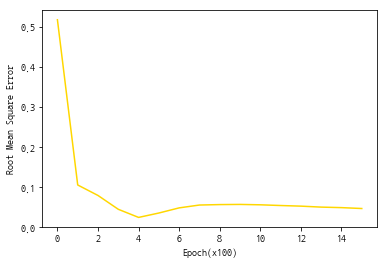

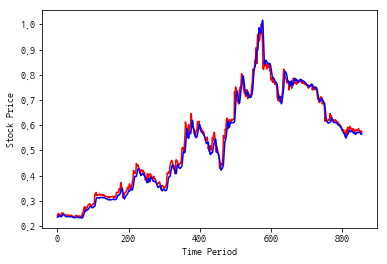

INFO:tensorflow:Restoring parameters from ./sessions/1460.ckpt
no code name rmse direction_error invest_result
1 1460 BYC 0.024038868 0.56942827 955098.35
seq_length :  4
hidden_dims :  [80, 144]
dropout_keep :  0.8
rmse_vals :  0.03556002


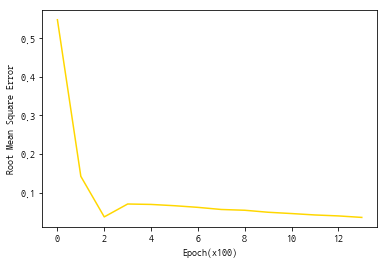

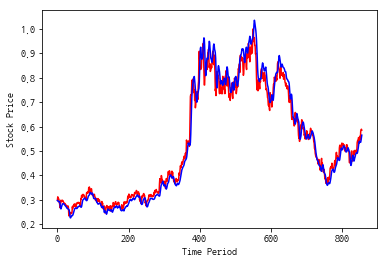

INFO:tensorflow:Restoring parameters from ./sessions/79160.ckpt
2 79160 CJ CGV 0.036933757 0.5192532 1000000
seq_length :  4
hidden_dims :  [80, 144]
dropout_keep :  0.8
rmse_vals :  0.025789663


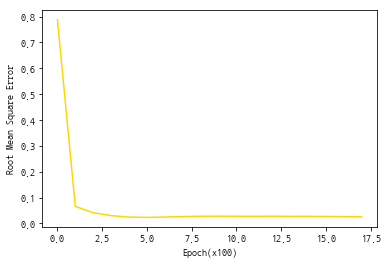

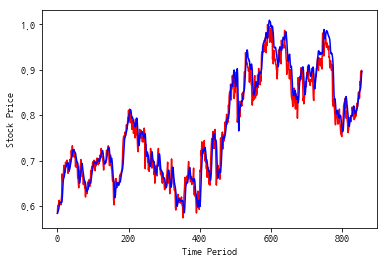

INFO:tensorflow:Restoring parameters from ./sessions/5830.ckpt
3 5830 DB손해보험 0.02490551 0.47841308 901173.9250000002


In [9]:
# 그래프를 그린다.
comp_rmses = []
no = 1;
for idx, row in stock_corps.iterrows():
    comp_code = row['종목코드']
    data = get_stock_datail(comp_code)
    data_params = get_train_test(data, train_params)
    _, rmse_val, direction_error_val, train_cnt = let_leaning(data_params, train_params, comp_code)
    
    now_money = let_invest(row, train_params, data_params, train_cnt)
    if idx == 0 :
        print('no', 'code', 'name', 'rmse', 'direction_error', 'invest_result')
    print(no, comp_code, row['회사명'], rmse_val, direction_error_val, now_money)
    comp_rmses.append([comp_code, row['회사명'], rmse_val, direction_error_val, now_money])
    if no == 3 :
        break;
    no += 1
    